# Prueba de código: Ingeniero de Datos - Orenes Core
Esta prueba está pensada para realizar la entrevista del puesto de Ingeniero de Datos. El objetivo es que este cuaderno sirva de hilo conductor en la entrevista técnica, la prueba está pensada para que puedas mostrar lo que sabes, no para descartar o acreditar candidatos. Es una herramienta a tu disposición, úsala de la forma que creas que mejor muestra tu conocimiento o tus cualidades. Por ejemplo: Si no puedes resolver un paso puedes simular la solución para mostrar otra cosa, si piensas que hay varias formas de resolver un problema o si piensas que hay algún añadido que no se pide siéntete libre de incluirlo.


La entrega consistirá en una copia de esta plantilla con los apartados completados y se revisará durante la entrevista. Esta plantilla no puede editarse, **ANTES DE EMPEZAR** puedes realizar una copia editable en Archivo/Guardar una Copia en Drive. Se valorará durante la entrevista si has llevado un control de versiones en git (usando GitHub por ejemplo).

## Entorno Spark
  Esta pieza de código te permitirá usar una interfaz de Spark en Colab para resolver tus ejercicios.

In [2]:
# Install pyspark
#!pip install pyspark
# Import SparkSession
from pyspark.sql import SparkSession

# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark
# Import a Spark function from library
from pyspark.sql.functions import col, max, mean

23/03/15 09:10:31 WARN Utils: Your hostname, LAP-120-anavarro resolves to a loopback address: 127.0.1.1; using 192.168.18.172 instead (on interface wlo1)
23/03/15 09:10:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/15 09:10:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import time
from matplotlib import pyplot as plt
import sns as sns

## Paso 1
Carga los datos del fichero housing_train.csv que guardado en la carpeta sample_data en un data frame de Spark.

Se hace uso del argumento "header", ya que los datos vienen con cabeceras, además se usa "inferSchema" ya que permite que a cada columna, se le asigne el mejor tipo de dato.

In [4]:
dataset_inicial = spark.read.csv("sample_data/housing_train.csv", header=True, inferSchema=True)
dataset_inicial.columns
dataset_inicial.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           73400.0|
|  -114.57|   33.57|              20.0|     1454.0|         326.0|     624.0|     262.0|        1.925|           65500.0|
+---------+--------+----

## Paso 2
Crea otro data frame a apartir de un muestreo aleatorio del 20% del data frame creado. Después crea otro data frames con el resto de registros. Comprueba que al unir los dos data frames creados no existen pérdidas ni duplicados de registors respecto al obtenido en el paso anterior.

Se extrae el 20% de los datos haciendo uso de la función "[sample](https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.DataFrame.sample.html)", que junto a su argumento "fraction" permite escoger el porcentaje de datos que se quiere extraer de forma ***aleatoria***, sin embargo para poder reproducir el ejercicio de forma exacta, se añade el argumento "seed".

In [5]:
muestra_df = dataset_inicial.sample(fraction=0.2, seed=1)

Para obtener un dataframe con el resto de datos, se hace usode la función "[exceptAll](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.DataFrame.exceptAll.html)".

In [6]:
resto_df = dataset_inicial.exceptAll(muestra_df)

A continuación se unen ambos df, haciendo uso de la función "[union](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.union.html)", la cual permite realizar un merge entre dos dataframe.

In [7]:
muestra_and_resto = muestra_df.union(resto_df)

Finalmente, para comprobar que no se ha producido ninguna pérdida durante el proceso, se comprueba la longitud tanto del dataframe inicial, como el resultado tras unir ambos dataframe. En este caso no se necesita comprobar los duplicado ya que se encarga la función "union", de eliminar los datos duplicados.

In [8]:
if muestra_and_resto.count() == dataset_inicial.count():
    print("No hay pérdidas ni duplicados al unir los DataFrames")
else:
    print("Se han perdido o duplicado registros al unir los DataFrames")

No hay pérdidas ni duplicados al unir los DataFrames


## Paso 3
Realiza un histograma de cada uno de los campos y compara los dos data frames creados en el paso anterior.

Con la siguiente función, lo que se consigue es solapar en un mismo histograma, las columnas que tengan el mismo nombre, de cada uno de los dataset que se pasen como parámetro.

In [9]:
def super_plot(df1, df2):
    for columna in df1.columns:
        plt.figure(figsize=(10, 5))
        sns.set_style("dark")
        sns.set_palette("Set2")
        sns.histplot(df1.select(columna).rdd.flatMap(lambda x: x).collect(), alpha=0.5, bins=20, label="Muestra")
        sns.histplot(df2.select(columna).rdd.flatMap(lambda x: x).collect(), alpha=0.2, bins=20, label="Resto")
        plt.ylabel("Frecuencia")
        plt.xlabel("Valor")
        plt.title(columna)
        plt.legend()
        plt.show()

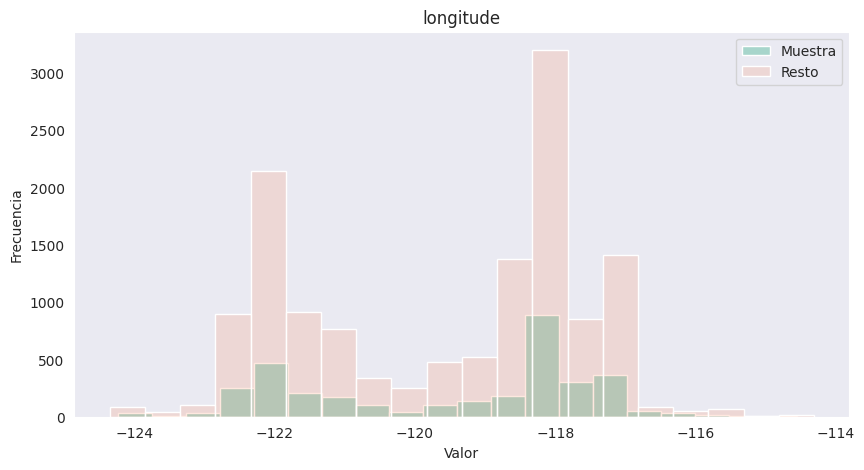

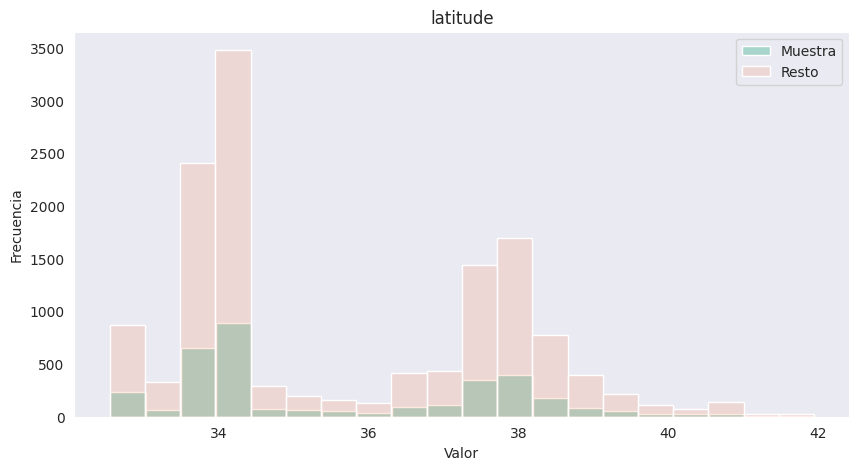

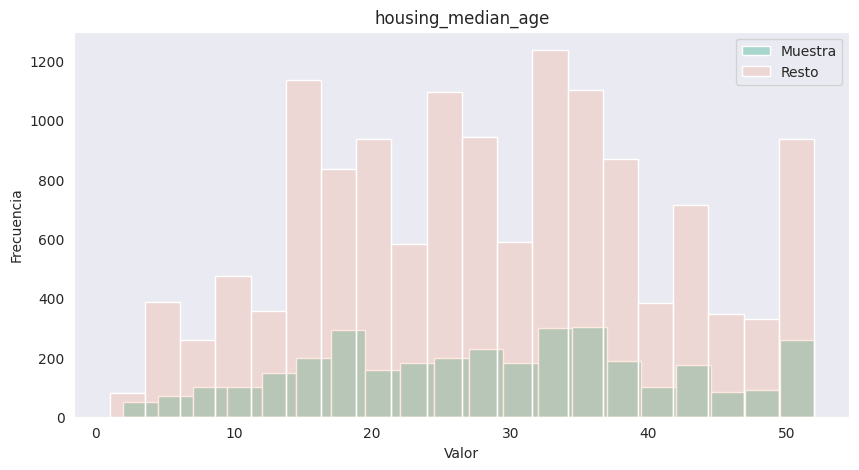

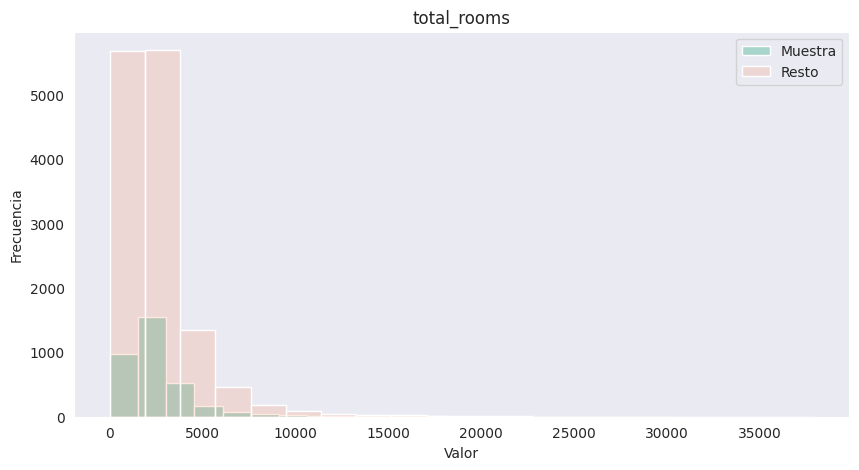

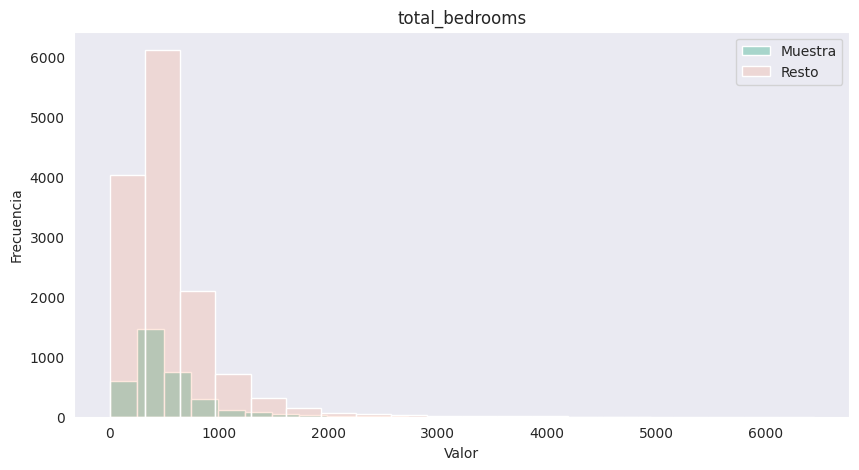

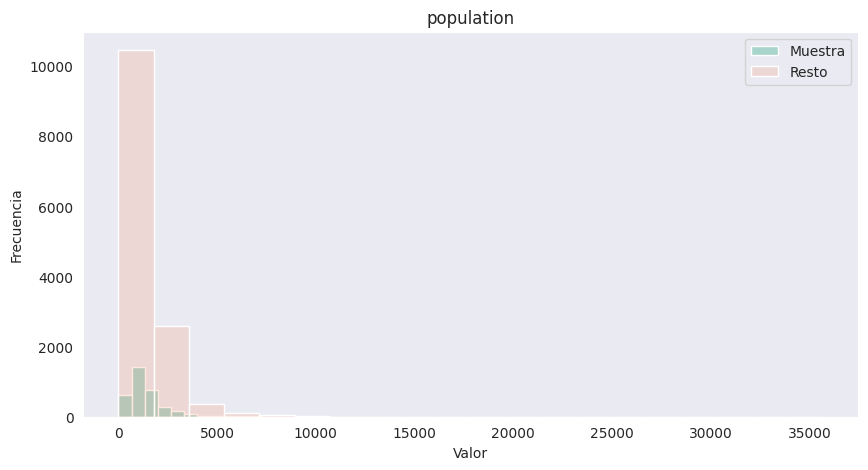

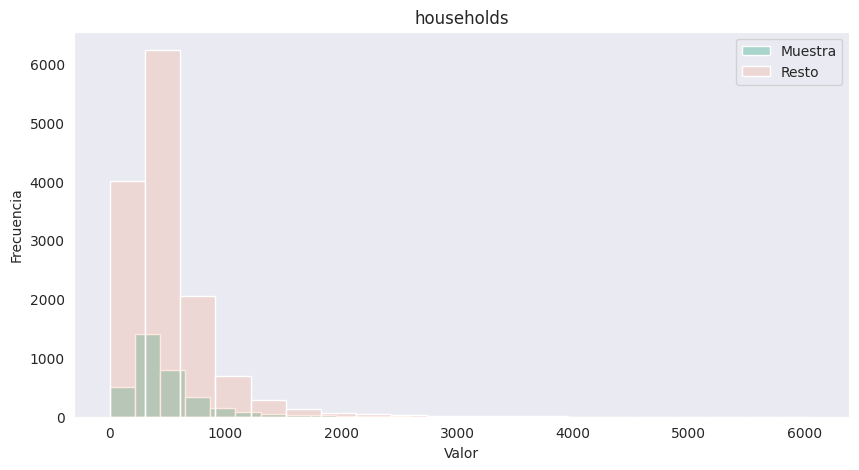

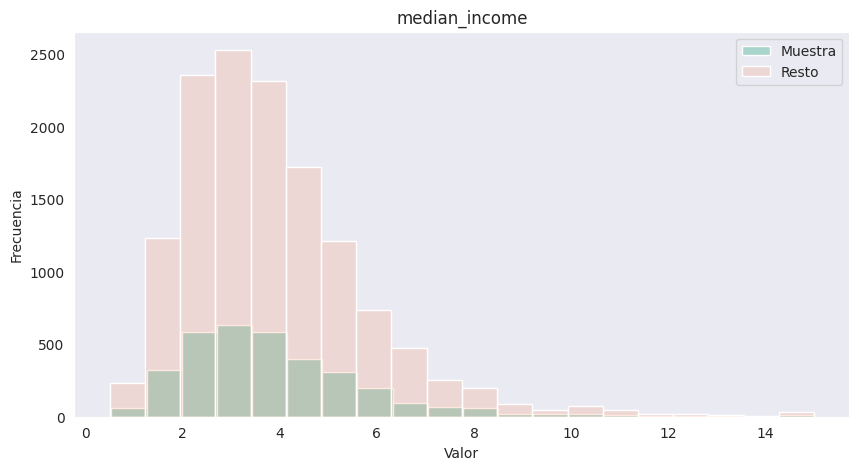

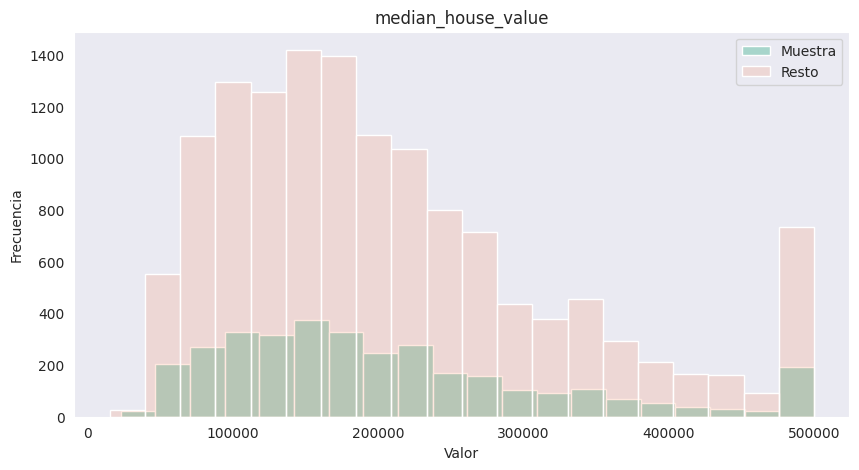

In [164]:
super_plot(muestra_df, resto_df)

Como conclusiones de ambos dataframe, una de las principales que podemos sacar, es que a pesar de tener menos valores, el dataframe con el 20% de los datos tiene la misma distribucion que el resto. Es decir, mantienen la del dataset original.

## Paso 4
Partiendo del data frame del primer paso. Obtén el registro que más al norte esté según el número de habitaciones que tenga. Es decir, el registro más al norte entre todos los registros con una sola habitación, el más al norte entre todos los registros de dos habitaciones, y así sucesivamente.

Se obtiene el número máximo de habitación en el dataframe. A continuación, por cada número de habitaciones, se coge del dataframe inicial, todas las filas que tenga el mismo número de habitaciones y de ellas, se escoge la habitación más al norte, es decir, ordenando de manera descendiente y cogiendo la primera fila.

In [169]:
def select_records_by_num_bedrooms_v1(df):
    max_rooms = df.select(max("total_rooms")).collect()[0][0]
    selected_records = []
    # Se recorren todos los número de habitaciones que hay
    for num_bedrooms in range(1, int(max_rooms) + 1):
        # Se seleccionan los registros con el número de habitaciones actual
        records = df.filter(col("total_rooms") == num_bedrooms)
        selected_record = records.orderBy("latitude").limit(1).collect()
        # Se comprueba que exista un registro para dicho número de abitación
        if selected_record:
            selected_record = selected_record[0]
            # Añadir el registro seleccionado a la lista
            selected_records.append(selected_record)
    return spark.createDataFrame(selected_records)

La opción anterior, tarda demasiado tiempo, ya que se hace un uso de un for, por lo que hay que ir iterando, sin embargo es más legible entender el código. Otra opción sería:
    - Agrupo por "total_bedrroms" (groupBy)
    - De cada agrupación, se coge la fila de mayor valor de latitude (max)

De esta manera haciendo uso de "groupBy" y de "agg", todo puede ser más rápido.

In [25]:
def select_records_by_num_bedrooms_v2(df):
    # Se agrupa por número de habitaciones y se obtiene el registro más al norte para cada grupo
    max_latitude_by_rooms = (dataset_inicial
                             .groupBy("total_rooms")
                             .agg(max(col("latitude")).alias("max_latitude"))
                             .withColumnRenamed("total_rooms", "total_rooms_y"))

    # Se une el DataFrame original con los registros más al norte para cada grupo
    joined_df = dataset_inicial.join(max_latitude_by_rooms, (dataset_inicial.latitude==max_latitude_by_rooms.max_latitude) & (dataset_inicial.total_rooms == max_latitude_by_rooms.total_rooms_y))

    # Se selecciona solo las columnas deseadas y ordenar por número de habitaciones
    result_df = (joined_df
                 .select("longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population",
                         "households", "median_income", "median_house_value")
                 .orderBy("total_rooms"))
    return result_df

**Comprobación del tiempo que tardan**

Iterando con un for. NO RECOMENDADO USAR ESTA CELDA, TARDA: 1922.5414271354675

In [171]:
# Se mide el tiempo de ejecución
star_time_v1 = time.time()
dataset_resultado = select_records_by_num_bedrooms_v1(dataset_inicial)
elapsed_time_v1 = time.time() - star_time_v1
print("Tiempo de ejecución de la función utilizando for: ", elapsed_time_v1)

# Se muestra el resultado
dataset_resultado.columns
dataset_resultado.show()

Tiempo de ejecución de la función utilizando for:  1922.5414271354675
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -117.79|   35.21|               4.0|        2.0|           2.0|       6.0|       2.0|        2.375|          137500.0|
|   -122.5|   37.79|              52.0|        8.0|           1.0|      13.0|       1.0|      15.0001|          500001.0|
|  -118.44|   34.28|              46.0|       11.0|          11.0|      24.0|      13.0|        2.875|          162500.0|
|  -122.29|   37.81|              46.0|       12.0|           4.0|      18.0|       7.0|       0.4999|           67500.0|
|  -122.37|    37.6|              26.0|       15.0|           3.0|      11.0

Utilizando "groupBy" y "agg"

In [26]:
# Se mide el tiempo de ejecución
star_time_v2 = time.time()
dataset_resultado_v2 = select_records_by_num_bedrooms_v2(dataset_inicial)
elapsed_time_v2 = time.time() - star_time_v2
print("Tiempo de ejecución de la función optimizada: ", elapsed_time_v2)

# Se muestra el resultado
dataset_resultado_v2.columns
dataset_resultado_v2.show()

Tiempo de ejecución de la función optimizada:  0.05355095863342285
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -117.79|   35.21|               4.0|        2.0|           2.0|       6.0|       2.0|        2.375|          137500.0|
|   -122.5|   37.79|              52.0|        8.0|           1.0|      13.0|       1.0|      15.0001|          500001.0|
|  -118.44|   34.28|              46.0|       11.0|          11.0|      24.0|      13.0|        2.875|          162500.0|
|  -122.29|   37.81|              46.0|       12.0|           4.0|      18.0|       7.0|       0.4999|           67500.0|
|  -122.37|    37.6|              26.0|       15.0|           3.0|      11.0|  

## Paso 5
Partiendo de los dos data frames del Paso 2. Calcula la media de las latitudes de los cada data frame agregado por el el número de dormitorios. Calcula las difrencias entre las medias de cada data frame para el mismo número de dormitorios. Es decir, la diferencia entre la latitud media de los registros del data frame del 20% con un solo dormitorio y la latitud media del data frame del 80% con un solo dormitorio; Realiza esta operación para todo número de habitaciones.

Se comienza, agrupando por la columna "total_bedrooms", seguidamente con la función "[agg](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.DataFrame.agg.html)", se calcula la media de cada grupo y finalmente se se nombra la columna.

In [112]:
media_muestra = muestra_df.groupBy("total_bedrooms").agg(mean("latitude").alias("mean_latitude_muestra")).orderBy(
    "total_bedrooms", ascendent=False)
print("Resultado dataset 20%")
media_muestra.show()

media_resto = resto_df.groupBy("total_bedrooms").agg(mean("latitude").alias("mean_latitude_resto")).orderBy(
    "total_bedrooms", ascendent=False)
print("Resultado dataset resto")
media_resto.show()

Resultado dataset 20%
+--------------+---------------------+
|total_bedrooms|mean_latitude_muestra|
+--------------+---------------------+
|           3.0|                 37.6|
|           4.0|               37.625|
|           5.0|                32.75|
|           9.0|                34.02|
|          10.0|                36.06|
|          11.0|    34.48333333333333|
|          12.0|               35.675|
|          13.0|                33.12|
|          14.0|                 33.8|
|          15.0|                37.98|
|          16.0|                35.24|
|          17.0|                35.32|
|          18.0|   36.449999999999996|
|          19.0|                33.83|
|          20.0|                35.78|
|          21.0|                38.59|
|          22.0|               34.045|
|          23.0|                33.96|
|          25.0|                33.28|
|          28.0|               35.715|
+--------------+---------------------+
only showing top 20 rows

Resultado datase

Una vez que ya tenemos cada tabla con su respectiva media para cada número de habitación, se realizan los siguientes pasos:
    - Se unen ambos dataframe, mediante la columna total_bedrooms, para así tener el número de habitación con sus correspondientes medias de cada dataframe.
    - Se crea la columna "diferencia", compuesta por la resta de cada una de las medias.
    - Finalmente se ordena de en función de la columna habitaciones.

In [115]:
diferencias = media_muestra.join(media_resto, "total_bedrooms") \
    .withColumn("diferencia", col("mean_latitude_muestra") - col("mean_latitude_resto")) \
    .orderBy("diferencia", ascending=False) \
    .select("total_bedrooms", "diferencia")
diferencias.show()

+--------------+-------------------+
|total_bedrooms|         diferencia|
+--------------+-------------------+
|        1856.0| -4.979999999999997|
|        1655.0| -4.899999999999999|
|        1324.0| -4.899999999999999|
|        1039.0| -4.630000000000003|
|        1542.0| -4.580000000000005|
|        1158.0| -4.479999999999997|
|          19.0| -4.240000000000002|
|          31.0| -4.229999999999997|
|        1893.0| -4.130000000000003|
|         858.0| -4.048333333333339|
|        1110.0| -4.035000000000004|
|        1213.0|-3.9299999999999997|
|         992.0|-3.9279999999999973|
|        1914.0|-3.8900000000000006|
|         714.0| -3.865000000000002|
|         117.0|-3.7674999999999983|
|        1575.0| -3.719999999999999|
|        1050.0|-3.6099999999999994|
|         870.0| -3.604999999999997|
|         907.0| -3.520000000000003|
+--------------+-------------------+
only showing top 20 rows



## Paso 6
Calcula cualquier medida que consideres interesante en utilizando Spark SQL. Por ejemplo, la media de dormitorios agrupado por las habitaciones que tiene cada registro.

Para calcular el número de dormitorios que hay de media, para aquellos registros que tienen el mismo número de habitaciones, primero agrupamos por el número de habitación (groupby), para finalmente calcular la media de cada grupo.

In [246]:
media_dormitorios_por_habitacion = dataset_inicial \
    .groupby("total_rooms").agg(mean("total_bedrooms") \
    .alias("media_dormitorios")).orderBy("total_rooms", ascending=False)
media_dormitorios_por_habitacion.show()

+-----------+-----------------+
|total_rooms|media_dormitorios|
+-----------+-----------------+
|    37937.0|           5471.0|
|    32627.0|           6445.0|
|    32054.0|           5290.0|
|    30405.0|           4093.0|
|    30401.0|           4957.0|
|    28258.0|           3864.0|
|    27700.0|           4179.0|
|    26322.0|           4072.0|
|    25957.0|           4798.0|
|    25187.0|           3521.0|
|    25135.0|           4819.0|
|    23866.0|           4407.0|
|    23386.0|           4171.0|
|    22128.0|           3522.0|
|    21897.0|           3513.0|
|    21533.0|           3078.0|
|    21113.0|           4386.0|
|    21086.0|           3945.0|
|    21060.0|           3366.0|
|    20982.0|           3392.0|
+-----------+-----------------+
only showing top 20 rows



Finalmente un dato muy interesante, es ver el valor medio de la casa en función de los años que tiene.

In [24]:
media_precio_por_edad = dataset_inicial\
    .groupby('housing_median_age').agg(mean("median_house_value") \
    .alias("median_house_value_age")).orderBy("median_house_value_age", ascending=False)
media_precio_por_edad.show()

+------------------+----------------------+
|housing_median_age|median_house_value_age|
+------------------+----------------------+
|              52.0|     277368.2005703422|
|              51.0|            244850.125|
|               3.0|    239450.04347826086|
|               4.0|     230054.1055900621|
|               2.0|    229438.83673469388|
|              48.0|    224665.25185185185|
|              45.0|    223464.74468085106|
|              25.0|     223097.2234273319|
|              50.0|    222513.48214285713|
|              49.0|     220667.6126126126|
|              44.0|    214909.50675675675|
|              22.0|      213129.173374613|
|              34.0|    213061.61552028218|
|               5.0|    211035.70854271358|
|              28.0|           210049.8125|
|              37.0|    209008.29977116705|
|              31.0|        208319.8515625|
|              36.0|    208262.42237762237|
|              24.0|     207293.3650385604|
|              32.0|            